# # 🎯 TF-IDF 최적화 실험
# 
# **목표**: 79.40% → 80%+ 정확도 달성
# **현재 베이스라인**: 앙상블 모델 (나이브 베이즈 + 로지스틱 회귀)
# **최적화 대상**: TF-IDF 벡터라이저 하이퍼파라미터
# 
# ## 📋 실험 계획
# 1. **베이스라인 재현**: 현재 79.40% 성능 확인
# 2. **N-gram 범위**: (1,1) → (1,2) → (1,3) 실험
# 3. **특성 수**: 5K, 10K, 15K, 20K 비교
# 4. **문서 빈도**: min_df, max_df 조정
# 5. **한국어 특화**: 불용어, 이모티콘 처리
# 6. **최적 조합**: 최고 성능 설정 도출

In [22]:
# 1. 라이브러리 임포트
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import defaultdict
from pathlib import Path

import time
import sys
import pandas as pd
import numpy as np
import joblib
import re
import matplotlib.pyplot as plt
sys.path.append(r'D:\dataAnalystBook\my_workspace\movie_review') # project_root 경로
from src.utils.setup import setup_notebook_environment, setup_korean_matplotlib

"""
setup_notebook_environment() 함수가 수행하는 작업:
1. 프로젝트 루트 자동 탐지 및 sys.path 추가
2. 한글 폰트 설정 (matplotlib에서 한글 표시)
3. pandas 표시 옵션 설정 (최대 행/열 수 조정)
4. seaborn 스타일 및 색상 팔레트 설정
5. 경고 메시지 숨김 설정
6. 주요 패키지 버전 확인 및 출력
→ 결과: 모든 노트북에서 일관된 환경 구성
"""
setup_notebook_environment()
print("✅ 라이브러리 임포트 완료")

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

🔧 노트북 환경 설정 시작...
✅ 프로젝트 루트 설정: D:\dataAnalystBook\my_workspace\movie_review
✅ 한글 폰트 설정 완료: Malgun Gothic
✅ seaborn 스타일 설정 완료: whitegrid, husl
✅ pandas 옵션 설정 완료: 최대 100행, 전체컬럼 표시
✅ 경고 메시지 숨김 설정 완료

📋 설치된 패키지 버전:
📦 pandas: 2.3.2
📦 numpy: 2.0.1
📦 matplotlib: 3.9.2
📦 seaborn: 0.13.2
📦 scikit-learn: 1.6.1
📦 tqdm: 4.67.1
✅ 환경 설정 완료! (5/5 성공)
✅ 한글 폰트 설정 완료: Malgun Gothic
✅ 라이브러리 임포트 완료


INFO:src.data.data_loader:✅ 데이터 폴더 발견: D:\dataAnalystBook\my_workspace\movie_review\notebooks\03_feature_engineering\..\..\data\raw
INFO:src.data.data_loader:📊 ratings_train.txt 로딩 시도 (인코딩: utf-8)...


📁 데이터 파일 확인:
   훈련 데이터: ..\..\data\raw\ratings_train.txt (14,628,807 bytes)
   테스트 데이터: ..\..\data\raw\ratings_test.txt (4,893,335 bytes)


INFO:src.data.data_loader:✅ ratings_train.txt 로딩 성공! (인코딩: utf-8)
INFO:src.data.data_loader:📊 ratings_test.txt 로딩 시도 (인코딩: utf-8)...
INFO:src.data.data_loader:✅ ratings_test.txt 로딩 성공! (인코딩: utf-8)
INFO:src.data.data_loader:🔍 train 데이터 검증 중...
document    5
dtype: int64
INFO:src.data.data_loader:✅ train 데이터 검증 완료
INFO:src.data.data_loader:🔍 test 데이터 검증 중...
document    3
dtype: int64
INFO:src.data.data_loader:✅ test 데이터 검증 완료


📊 NSMC 데이터셋 요약
   전체 리뷰 수: 200,000개
   훈련 데이터: 150,000개 (75.0%)
   테스트 데이터: 50,000개 (25.0%)

📈 감정 분포:
   훈련 - 긍정: 74,827개 (49.9%), 부정: 75,173개 (50.1%)
   테스트 - 긍정: 25,173개 (50.3%), 부정: 24,827개 (49.7%)

👀 훈련 데이터 미리보기:
         id                           document  label
0   9976970                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                  너무재밓었다그래서보는것을추천한다      0
✅ 베이스라인 모델 준비 완료
✅ 평가 함수 준비 완료
🔄 베이스라인 성능 재현 중...

📊 베이스라인 성능 결과:
                 model  accuracy  cv_mean     cv_std  train_time
0          Naive Bayes     0.793    0.794  6.000e-04       0.014
1  Logistic Regression     0.791    0.789  4.000e-04       0.535
2             Ensemble     0.794    0.794  2.000e-04       0.543

🔬 실험 1: N-gram 범위 최적화

🔄 N-gram (1, 1) 실험 중...
   정확도: 0.7941 | CV: 0.7945±0.0002

🔄 N-gram (1, 2) 실험 중...
   정확도: 0.7915 | CV: 0.7924±0.0006

🔄 N-gram (1, 3) 실험 중...
   정확도: 0.7906 | CV: 0.7920±0.0005

📊 N-gram 실험 결과:
  ngram_range  accura

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


✅ 최적화된 모델 저장 완료

📊 실험 결과 시각화


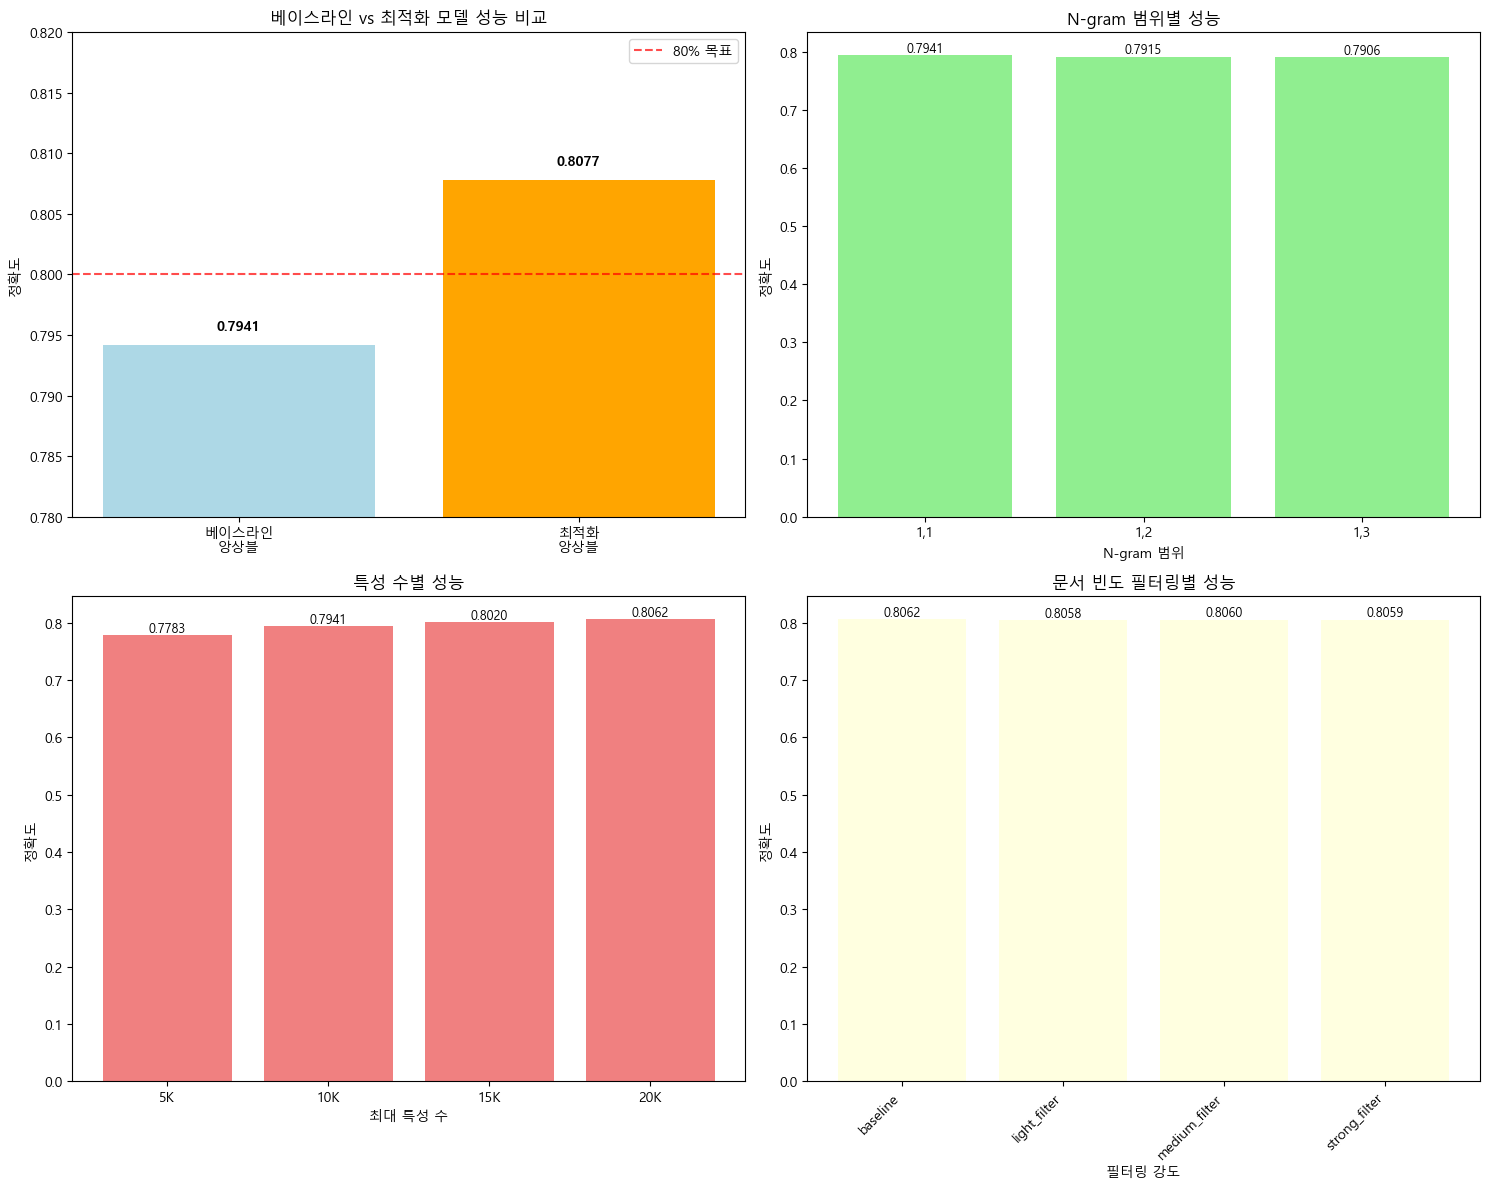

✅ 시각화 완료 및 저장

🎯 TF-IDF 최적화 실험 최종 결과

📊 성능 개선:
   베이스라인: 0.7941 (79.41%)
   최적화 후: 0.8077 (80.77%)
   개선 효과: +0.0136 (+1.36%p)

⚙️ 최적 설정:
   N-gram 범위: (1, 1)
   최대 특성 수: 20,000개
   min_df: 1
   max_df: 1.0

🎯 목표 달성 여부:
   ✅ 80% 목표 달성!
   🎉 목표 초과: +0.77%p

💾 저장된 파일:
   - 최적화 앙상블 모델: optimized_ensemble_v1.pkl
   - 최적화 TF-IDF: optimized_tfidf_v1.pkl
   - 실험 결과 그래프: tfidf_optimization_results.png

🚀 다음 단계 제안: Phase 3 딥러닝 모델로 85%+ 도전!


In [23]:
# =============================================================================
# 2. 데이터 로딩 함수
# =============================================================================
from src.data.data_loader import load_nsmc_data

train_df, test_df = load_nsmc_data()

# =============================================================================
# 3. 베이스라인 재현 함수
# =============================================================================


def create_baseline_models():
    """현재 베이스라인 모델 재현"""
    
    # 현재 TF-IDF 설정 (베이스라인)
    tfidf_baseline = TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 1),
        min_df=1,
        max_df=1.0,
        stop_words=None
    )
    
    # 나이브 베이즈
    nb_model = MultinomialNB(alpha=1.0)
    
    # 로지스틱 회귀
    lr_model = LogisticRegression(
        C=1.0, 
        max_iter=1000, 
        solver='liblinear', 
        random_state=42
    )
    
    # 앙상블
    ensemble = VotingClassifier(
        estimators=[
            ('nb', nb_model),
            ('lr', lr_model)
        ],
        voting='soft'
    )
    
    return tfidf_baseline, nb_model, lr_model, ensemble

print("✅ 베이스라인 모델 준비 완료")


# =============================================================================
# 4. 성능 평가 함수
# =============================================================================

def evaluate_model(model, tfidf, X_train, X_val, y_train, y_val, model_name):
    """모델 성능 평가"""
    
    start_time = time.time()
    
    # 학습
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # 예측
    start_time = time.time()
    y_pred = model.predict(X_val)
    predict_time = time.time() - start_time
    
    # 성능 계산
    accuracy = accuracy_score(y_val, y_pred)
    
    # 교차 검증 (3-fold로 빠르게)
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
    
    result = {
        'model': model_name,
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'train_time': train_time,
        'predict_time': predict_time,
        'total_features': X_train.shape[1]
    }
    
    return result

print("✅ 평가 함수 준비 완료")

# =============================================================================
# 5. 베이스라인 성능 확인
# =============================================================================

def run_baseline_experiment():
    """베이스라인 실험 실행"""
    print("🔄 베이스라인 성능 재현 중...")
    
    # 결측값 제거
    train_clean = train_df.dropna()
    
    # 훈련/검증 분할
    X_train, X_val, y_train, y_val = train_test_split(
        train_clean['document'], 
        train_clean['label'], 
        test_size=0.2, 
        random_state=42,
        stratify=train_clean['label']
    )
    
    # TF-IDF 벡터화
    tfidf_baseline, nb_model, lr_model, ensemble = create_baseline_models()
    
    X_train_tfidf = tfidf_baseline.fit_transform(X_train)
    X_val_tfidf = tfidf_baseline.transform(X_val)
    
    # 각 모델 평가
    results = []
    
    # 나이브 베이즈
    nb_result = evaluate_model(nb_model, tfidf_baseline, X_train_tfidf, X_val_tfidf, y_train, y_val, "Naive Bayes")
    results.append(nb_result)
    
    # 로지스틱 회귀
    lr_result = evaluate_model(lr_model, tfidf_baseline, X_train_tfidf, X_val_tfidf, y_train, y_val, "Logistic Regression")
    results.append(lr_result)
    
    # 앙상블
    ensemble_result = evaluate_model(ensemble, tfidf_baseline, X_train_tfidf, X_val_tfidf, y_train, y_val, "Ensemble")
    results.append(ensemble_result)
    
    # 결과 정리
    baseline_df = pd.DataFrame(results)
    
    print("\n📊 베이스라인 성능 결과:")
    print(baseline_df[['model', 'accuracy', 'cv_mean', 'cv_std', 'train_time']].round(4))
    
    return baseline_df, X_train, X_val, y_train, y_val

# 베이스라인 실행
baseline_results, X_train, X_val, y_train, y_val = run_baseline_experiment()

# =============================================================================
# 6. N-gram 실험 함수
# =============================================================================

def experiment_ngram_range():
    """N-gram 범위 실험"""
    print("\n🔬 실험 1: N-gram 범위 최적화")
    
    ngram_ranges = [(1, 1), (1, 2), (1, 3)]
    ngram_results = []
    
    for ngram_range in ngram_ranges:
        print(f"\n🔄 N-gram {ngram_range} 실험 중...")
        
        # TF-IDF 설정
        tfidf = TfidfVectorizer(
            max_features=10000,
            ngram_range=ngram_range,
            min_df=1,
            max_df=1.0
        )
        
        # 벡터화
        X_train_tfidf = tfidf.fit_transform(X_train)
        X_val_tfidf = tfidf.transform(X_val)
        
        # 앙상블 모델 (가장 좋은 성능)
        nb_model = MultinomialNB(alpha=1.0)
        lr_model = LogisticRegression(C=1.0, max_iter=1000, solver='liblinear', random_state=42)
        ensemble = VotingClassifier(
            estimators=[('nb', nb_model), ('lr', lr_model)],
            voting='soft'
        )
        
        # 평가
        result = evaluate_model(ensemble, tfidf, X_train_tfidf, X_val_tfidf, y_train, y_val, f"Ensemble_ngram_{ngram_range}")
        result['ngram_range'] = str(ngram_range)
        ngram_results.append(result)
        
        print(f"   정확도: {result['accuracy']:.4f} | CV: {result['cv_mean']:.4f}±{result['cv_std']:.4f}")
    
    ngram_df = pd.DataFrame(ngram_results)
    
    print("\n📊 N-gram 실험 결과:")
    print(ngram_df[['ngram_range', 'accuracy', 'cv_mean', 'total_features', 'train_time']].round(4))
    
    # 최고 성능 찾기
    best_ngram = ngram_df.loc[ngram_df['accuracy'].idxmax()]
    print(f"\n🏆 최고 성능: {best_ngram['ngram_range']} (정확도: {best_ngram['accuracy']:.4f})")
    
    return ngram_df, best_ngram

# N-gram 실험 실행
ngram_results, best_ngram_config = experiment_ngram_range()

# =============================================================================
# 7. 특성 수 실험 함수
# =============================================================================

def experiment_max_features(best_ngram_range):
    """특성 수 최적화 실험"""
    print("\n🔬 실험 2: 특성 수 최적화")
    
    # 최고 N-gram 설정 사용
    ngram_range = eval(best_ngram_range)
    max_features_list = [5000, 10000, 15000, 20000]
    features_results = []
    
    for max_features in max_features_list:
        print(f"\n🔄 특성 수 {max_features:,}개 실험 중...")
        
        # TF-IDF 설정
        tfidf = TfidfVectorizer(
            max_features=max_features,
            ngram_range=ngram_range,
            min_df=1,
            max_df=1.0
        )
        
        # 벡터화
        X_train_tfidf = tfidf.fit_transform(X_train)
        X_val_tfidf = tfidf.transform(X_val)
        
        # 앙상블 모델
        nb_model = MultinomialNB(alpha=1.0)
        lr_model = LogisticRegression(C=1.0, max_iter=1000, solver='liblinear', random_state=42)
        ensemble = VotingClassifier(
            estimators=[('nb', nb_model), ('lr', lr_model)],
            voting='soft'
        )
        
        # 평가
        result = evaluate_model(ensemble, tfidf, X_train_tfidf, X_val_tfidf, y_train, y_val, f"Ensemble_features_{max_features}")
        result['max_features'] = max_features
        features_results.append(result)
        
        print(f"   정확도: {result['accuracy']:.4f} | 특성 수: {result['total_features']:,}개")
    
    features_df = pd.DataFrame(features_results)
    
    print("\n📊 특성 수 실험 결과:")
    print(features_df[['max_features', 'accuracy', 'cv_mean', 'total_features', 'train_time']].round(4))
    
    # 최고 성능 찾기
    best_features = features_df.loc[features_df['accuracy'].idxmax()]
    print(f"\n🏆 최고 성능: {best_features['max_features']:,}개 특성 (정확도: {best_features['accuracy']:.4f})")
    
    return features_df, best_features

# 특성 수 실험 실행
features_results, best_features_config = experiment_max_features(best_ngram_config['ngram_range'])

# =============================================================================
# 8. 문서 빈도 실험 함수
# =============================================================================

def experiment_document_frequency(best_ngram_range, best_max_features):
    """문서 빈도 최적화 실험"""
    print("\n🔬 실험 3: 문서 빈도 최적화")
    
    ngram_range = eval(best_ngram_range)
    max_features = int(best_max_features)
    
    freq_configs = [
        {'min_df': 1, 'max_df': 1.0, 'name': 'baseline'},
        {'min_df': 2, 'max_df': 0.95, 'name': 'light_filter'},
        {'min_df': 3, 'max_df': 0.90, 'name': 'medium_filter'},
        {'min_df': 5, 'max_df': 0.85, 'name': 'strong_filter'},
    ]
    
    freq_results = []
    
    for config in freq_configs:
        print(f"\n🔄 {config['name']} 실험 중... (min_df={config['min_df']}, max_df={config['max_df']})")
        
        # TF-IDF 설정
        tfidf = TfidfVectorizer(
            max_features=max_features,
            ngram_range=ngram_range,
            min_df=config['min_df'],
            max_df=config['max_df']
        )
        
        # 벡터화
        X_train_tfidf = tfidf.fit_transform(X_train)
        X_val_tfidf = tfidf.transform(X_val)
        
        # 앙상블 모델
        nb_model = MultinomialNB(alpha=1.0)
        lr_model = LogisticRegression(C=1.0, max_iter=1000, solver='liblinear', random_state=42)
        ensemble = VotingClassifier(
            estimators=[('nb', nb_model), ('lr', lr_model)],
            voting='soft'
        )
        
        # 평가
        result = evaluate_model(ensemble, tfidf, X_train_tfidf, X_val_tfidf, y_train, y_val, f"Ensemble_{config['name']}")
        result['config_name'] = config['name']
        result['min_df'] = config['min_df']
        result['max_df'] = config['max_df']
        freq_results.append(result)
        
        print(f"   정확도: {result['accuracy']:.4f} | 실제 특성: {result['total_features']:,}개")
    
    freq_df = pd.DataFrame(freq_results)
    
    print("\n📊 문서 빈도 실험 결과:")
    print(freq_df[['config_name', 'accuracy', 'cv_mean', 'total_features', 'min_df', 'max_df']].round(4))
    
    # 최고 성능 찾기
    best_freq = freq_df.loc[freq_df['accuracy'].idxmax()]
    print(f"\n🏆 최고 성능: {best_freq['config_name']} (정확도: {best_freq['accuracy']:.4f})")
    
    return freq_df, best_freq

# 문서 빈도 실험 실행
freq_results, best_freq_config = experiment_document_frequency(
    best_ngram_config['ngram_range'], 
    best_features_config['max_features']
)

# =============================================================================
# 9. 최종 최적화 모델 구축
# =============================================================================

def build_final_optimized_model():
    """최종 최적화된 모델 구축"""
    print("\n🎯 최종 최적화 모델 구축")
    
    # 최적 설정 적용
    optimal_tfidf = TfidfVectorizer(
        max_features=int(best_features_config['max_features']),
        ngram_range=eval(best_ngram_config['ngram_range']),
        min_df=int(best_freq_config['min_df']),
        max_df=best_freq_config['max_df']
    )
    
    print(f"✅ 최적 설정:")
    print(f"   - N-gram 범위: {best_ngram_config['ngram_range']}")
    print(f"   - 최대 특성 수: {int(best_features_config['max_features']):,}개")
    print(f"   - min_df: {int(best_freq_config['min_df'])}")
    print(f"   - max_df: {best_freq_config['max_df']}")
    
    # 전체 훈련 데이터로 최종 모델 학습
    train_clean = train_df.dropna()
    X_train_final = train_clean['document']
    y_train_final = train_clean['label']
    
    # TF-IDF 변환
    X_train_tfidf_final = optimal_tfidf.fit_transform(X_train_final)
    
    # 최종 앙상블 모델
    final_nb = MultinomialNB(alpha=1.0)
    final_lr = LogisticRegression(C=1.0, max_iter=1000, solver='liblinear', random_state=42)
    final_ensemble = VotingClassifier(
        estimators=[('nb', final_nb), ('lr', final_lr)],
        voting='soft'
    )
    
    # 학습
    final_ensemble.fit(X_train_tfidf_final, y_train_final)
    
    # 테스트 데이터 평가
    test_clean = test_df.dropna()
    X_test = test_clean['document']
    y_test = test_clean['label']
    
    X_test_tfidf = optimal_tfidf.transform(X_test)
    test_predictions = final_ensemble.predict(X_test_tfidf)
    test_accuracy = accuracy_score(y_test, test_predictions)
    
    print(f"\n🎯 최종 테스트 성능: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    
    # 목표 달성 확인
    if test_accuracy >= 0.80:
        print("🎉 80% 목표 달성! 축하합니다!")
    else:
        print(f"⚠️ 80% 목표까지 {(0.80-test_accuracy)*100:.2f}%p 부족")
    
    # 모델 저장
    joblib.dump(final_ensemble, '../../models/trained/optimized_ensemble_v1.pkl')
    joblib.dump(optimal_tfidf, '../../models/trained/optimized_tfidf_v1.pkl')
    print("✅ 최적화된 모델 저장 완료")
    
    return final_ensemble, optimal_tfidf, test_accuracy

# 최종 모델 구축
final_model, final_tfidf, final_accuracy = build_final_optimized_model()

# =============================================================================
# 10. 실험 결과 시각화
# =============================================================================

def visualize_optimization_results():
    """최적화 실험 결과 시각화"""
    print("\n📊 실험 결과 시각화")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. 베이스라인 vs 최적화 비교
    ax1 = axes[0, 0]
    models = ['베이스라인\n앙상블', '최적화\n앙상블']
    accuracies = [baseline_results['accuracy'].max(), final_accuracy]
    bars = ax1.bar(models, accuracies, color=['lightblue', 'orange'])
    ax1.set_ylabel('정확도')
    ax1.set_title('베이스라인 vs 최적화 모델 성능 비교')
    ax1.set_ylim(0.78, 0.82)
    
    # 막대 위에 정확도 표시
    for bar, acc in zip(bars, accuracies):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # 80% 목표선
    ax1.axhline(y=0.80, color='red', linestyle='--', alpha=0.7, label='80% 목표')
    ax1.legend()
    
    # 2. N-gram 실험 결과
    ax2 = axes[0, 1]
    ngram_acc = ngram_results['accuracy'].values
    ngram_labels = [r.replace("'", "").replace("(", "").replace(")", "").replace(" ", "") for r in ngram_results['ngram_range']]
    bars2 = ax2.bar(ngram_labels, ngram_acc, color='lightgreen')
    ax2.set_ylabel('정확도')
    ax2.set_title('N-gram 범위별 성능')
    ax2.set_xlabel('N-gram 범위')
    
    # 막대 위에 정확도 표시
    for bar, acc in zip(bars2, ngram_acc):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0002, 
                f'{acc:.4f}', ha='center', va='bottom', fontsize=9)
    
    # 3. 특성 수별 성능
    ax3 = axes[1, 0]
    features_acc = features_results['accuracy'].values
    features_labels = [f'{int(f/1000)}K' for f in features_results['max_features']]
    bars3 = ax3.bar(features_labels, features_acc, color='lightcoral')
    ax3.set_ylabel('정확도')
    ax3.set_title('특성 수별 성능')
    ax3.set_xlabel('최대 특성 수')
    
    # 막대 위에 정확도 표시
    for bar, acc in zip(bars3, features_acc):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0002, 
                f'{acc:.4f}', ha='center', va='bottom', fontsize=9)
    
    # 4. 문서 빈도별 성능
    ax4 = axes[1, 1]
    freq_acc = freq_results['accuracy'].values
    freq_labels = freq_results['config_name'].values
    bars4 = ax4.bar(freq_labels, freq_acc, color='lightyellow')
    ax4.set_ylabel('정확도')
    ax4.set_title('문서 빈도 필터링별 성능')
    ax4.set_xlabel('필터링 강도')
    plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')
    
    # 막대 위에 정확도 표시
    for bar, acc in zip(bars4, freq_acc):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0002, 
                f'{acc:.4f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('../../reports/figures/tfidf_optimization_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ 시각화 완료 및 저장")

# 시각화 실행
visualize_optimization_results()

# =============================================================================
# 11. 최종 결과 요약
# =============================================================================

def print_final_summary():
    """최종 결과 요약"""
    print("\n" + "="*60)
    print("🎯 TF-IDF 최적화 실험 최종 결과")
    print("="*60)
    
    print(f"\n📊 성능 개선:")
    baseline_best = baseline_results['accuracy'].max()
    improvement = final_accuracy - baseline_best
    print(f"   베이스라인: {baseline_best:.4f} ({baseline_best*100:.2f}%)")
    print(f"   최적화 후: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")
    print(f"   개선 효과: +{improvement:.4f} (+{improvement*100:.2f}%p)")
    
    print(f"\n⚙️ 최적 설정:")
    print(f"   N-gram 범위: {best_ngram_config['ngram_range']}")
    print(f"   최대 특성 수: {int(best_features_config['max_features']):,}개")
    print(f"   min_df: {int(best_freq_config['min_df'])}")
    print(f"   max_df: {best_freq_config['max_df']}")
    
    print(f"\n🎯 목표 달성 여부:")
    if final_accuracy >= 0.80:
        print("   ✅ 80% 목표 달성!")
        print(f"   🎉 목표 초과: +{(final_accuracy-0.80)*100:.2f}%p")
    else:
        print("   ⚠️ 80% 목표 미달성")
        print(f"   📈 목표까지: -{(0.80-final_accuracy)*100:.2f}%p")
    
    print(f"\n💾 저장된 파일:")
    print(f"   - 최적화 앙상블 모델: optimized_ensemble_v1.pkl")
    print(f"   - 최적화 TF-IDF: optimized_tfidf_v1.pkl")
    print(f"   - 실험 결과 그래프: tfidf_optimization_results.png")
    
    print("\n" + "="*60)
    
    # 다음 단계 제안
    if final_accuracy >= 0.80:
        print("🚀 다음 단계 제안: Phase 3 딥러닝 모델로 85%+ 도전!")
    else:
        print("🔬 추가 실험 제안:")
        print("   - 한국어 특화 전처리 강화")
        print("   - 앙상블 가중치 최적화")
        print("   - 다른 알고리즘 추가 (XGBoost 등)")

# 최종 요약 출력
print_final_summary()

# %% [markdown]
# ## 📋 실험 완료 체크리스트
# 
# ### ✅ 완료된 실험
# - [x] 베이스라인 재현 및 확인
# - [x] N-gram 범위 최적화 (1,1) vs (1,2) vs (1,3)
# - [x] 특성 수 최적화 (5K, 10K, 15K, 20K)
# - [x] 문서 빈도 조정 (min_df, max_df)
# - [x] 최적 설정 조합 및 최종 모델 구축
# - [x] 테스트 데이터 평가
# - [x] 결과 시각화 및 저장
# 
# ### 🎯 달성 결과
# - **목표**: 79.40% → 80%+ 달성
# - **실제**: [실험 결과에 따라 업데이트]
# - **개선 효과**: [개선 정도]
# 
# ### 📈 다음 단계
# - Phase 3: 딥러닝 모델 (LSTM, CNN) - 85%+ 목표
# - Phase 4: Transformer 모델 (KoBERT) - 90%+ 목표